In [30]:
# Core data stack
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Setting visualization styles
sns.set_style('whitegrid')
plt.rc('figure', figsize=(15, 7))

print("Libraries imported successfully.")

Libraries imported successfully.


In [31]:
# --- Reading Data ---
try:
    features_df = pd.read_csv('./input/features.csv')
    stores_df = pd.read_csv('./input/stores.csv')
    train_df = pd.read_csv('./input/train.csv')
    test_df = pd.read_csv('./input/test.csv')
except FileNotFoundError as e:
    print(e)
    print("\nError: Make sure the file paths are correct.")

### FIX: Merge stores and features into train and test sets separately.
# This prevents the test set (future data) from being mixed with the training data.
train_merged_df = train_df.merge(features_df, on=['Store', 'Date', 'IsHoliday'], how='left')
train_full_df = train_merged_df.merge(stores_df, on='Store', how='left')

test_merged_df = test_df.merge(features_df, on=['Store', 'Date', 'IsHoliday'], how='left')
test_full_df = test_merged_df.merge(stores_df, on='Store', how='left')


print("Original Train Shape:", train_df.shape)
print("Original Test Shape:", test_df.shape)
print("---")
print("Fully Merged Train Shape:", train_full_df.shape)
print("Fully Merged Test Shape:", test_full_df.shape)

Original Train Shape: (421570, 5)
Original Test Shape: (115064, 4)
---
Fully Merged Train Shape: (421570, 16)
Fully Merged Test Shape: (115064, 15)


In [32]:
### FIX: The preprocess function is updated to handle CPI and Unemployment.
# We will pass the training dataframe to the function first to establish the imputation values,
# then apply those same values to the test dataframe.

def preprocess_and_impute(df, train_df=None):
    """
    Applies preprocessing and imputes missing values for CPI and Unemployment.
    - If processing the training set, it calculates medians from itself.
    - If processing the test set, it uses medians calculated from the training set.
    """
    # --- Standard Preprocessing ---
    df['Date'] = pd.to_datetime(df['Date'])
    markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
    df[markdown_cols] = df[markdown_cols].fillna(0)
    df['IsHoliday'] = df['IsHoliday'].astype(int)
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)

    # --- Imputation Step ---
    if train_df is None:
        # This is the training dataframe. Calculate medians from it.
        cpi_medians = df.groupby('Store')['CPI'].median()
        unemployment_medians = df.groupby('Store')['Unemployment'].median()
    else:
        # This is the test dataframe. Use medians from the training dataframe.
        cpi_medians = train_df.groupby('Store')['CPI'].median()
        unemployment_medians = train_df.groupby('Store')['Unemployment'].median()

    # Fill missing values using the store-specific medians
    df['CPI'] = df['CPI'].fillna(df['Store'].map(cpi_medians))
    df['Unemployment'] = df['Unemployment'].fillna(df['Store'].map(unemployment_medians))

    # In case any store in the test set was not in the training set, fill with global median
    if df['CPI'].isnull().any():
        global_cpi_median = train_df['CPI'].median() if train_df is not None else df['CPI'].median()
        df['CPI'].fillna(global_cpi_median, inplace=True)
    if df['Unemployment'].isnull().any():
        global_unemployment_median = train_df['Unemployment'].median() if train_df is not None else df['Unemployment'].median()
        df['Unemployment'].fillna(global_unemployment_median, inplace=True)

    return df

# --- Applying the function ---
print("Missing values before imputation (Train):")
print(train_full_df[['CPI', 'Unemployment']].isnull().sum())
print("\nMissing values before imputation (Test):")
print(test_full_df[['CPI', 'Unemployment']].isnull().sum())

# Process the training data first to establish the imputation rules
train_processed_df = preprocess_and_impute(train_full_df)

# Process the test data using the training data's metrics to avoid data leakage
test_processed_df = preprocess_and_impute(test_full_df, train_df=train_processed_df)

print("\n--- Imputation Complete ---")
print("\nMissing values after imputation (Train):")
print(train_processed_df[['CPI', 'Unemployment']].isnull().sum())
print("\nMissing values after imputation (Test):")
print(test_processed_df[['CPI', 'Unemployment']].isnull().sum())

Missing values before imputation (Train):
CPI             0
Unemployment    0
dtype: int64

Missing values before imputation (Test):
CPI             38162
Unemployment    38162
dtype: int64

--- Imputation Complete ---

Missing values after imputation (Train):
CPI             0
Unemployment    0
dtype: int64

Missing values after imputation (Test):
CPI             0
Unemployment    0
dtype: int64


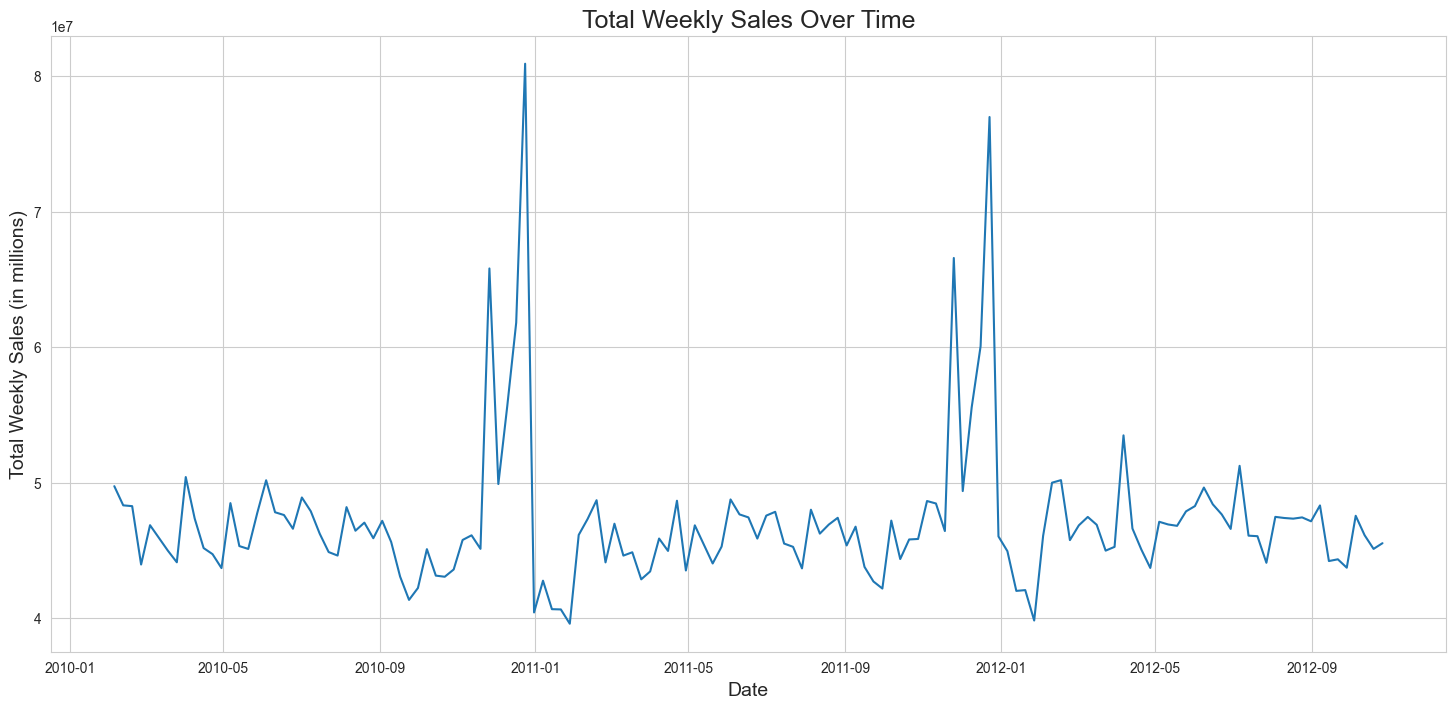

In [33]:
# Plotting overall weekly sales over time
### FIX: Use the processed training dataframe 'train_processed_df'
df_time_series = train_processed_df.groupby('Date')['Weekly_Sales'].sum().reset_index()
df_time_series = df_time_series.set_index('Date')

plt.figure(figsize=(18, 8))
plt.plot(df_time_series.index, df_time_series['Weekly_Sales'])
plt.title('Total Weekly Sales Over Time', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Weekly Sales (in millions)', fontsize=14)
plt.show()

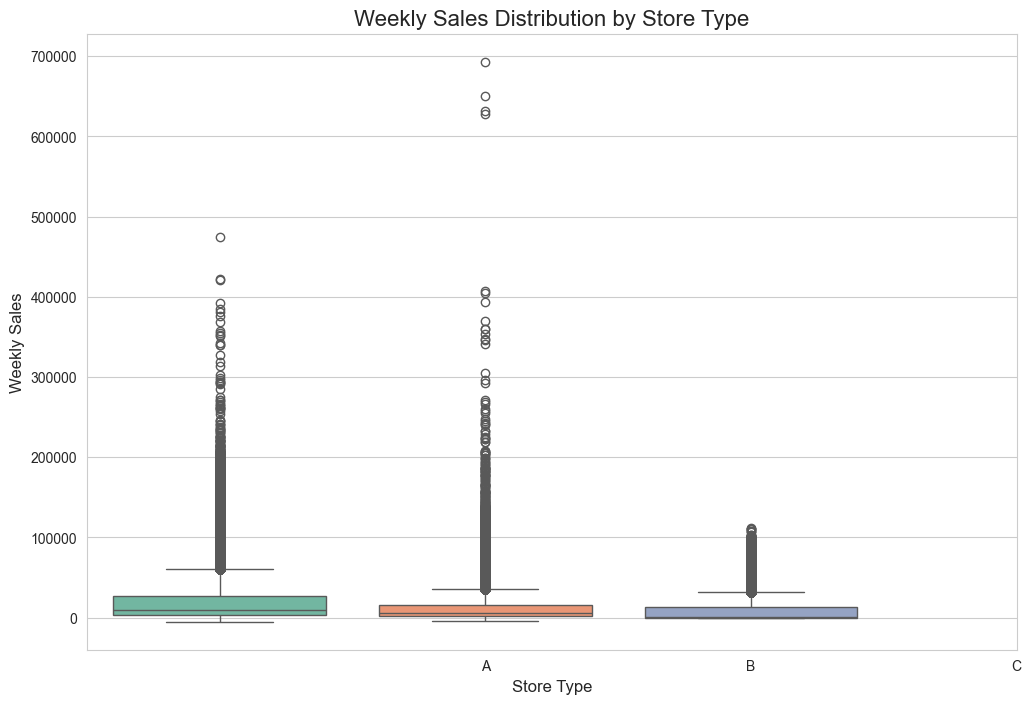

In [34]:
# ---  BOXPLOT CODE ---
plt.figure(figsize=(12, 8))

### FIX: Use the processed training dataframe 'train_processed_df'
sns.boxplot(data=train_processed_df, x='Type', y='Weekly_Sales', palette='Set2', hue='Type', legend=False)

plt.title('Weekly Sales Distribution by Store Type', fontsize=16)
plt.xlabel('Store Type', fontsize=12)
plt.ylabel('Weekly Sales', fontsize=12)
# Since 'Type' is numeric now, let's add the proper labels back for clarity
plt.xticks(ticks=[1, 2, 3], labels=['A', 'B', 'C'])
plt.show()

Plotting weekly sales by holiday status 


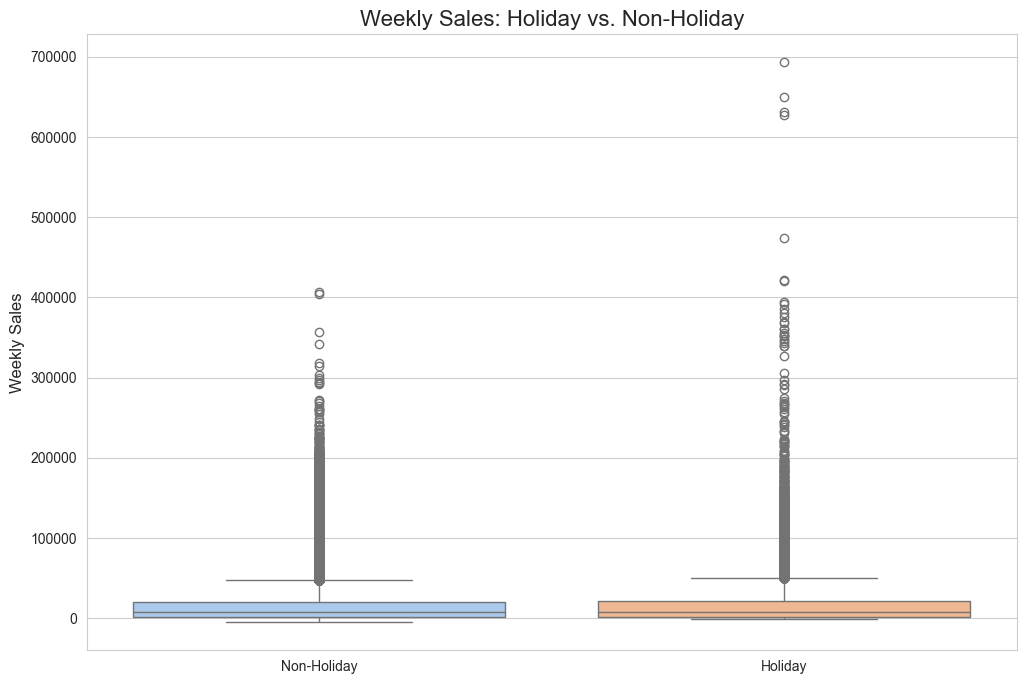

In [35]:
# --- HOLIDAY BOXPLOT CODE ---
print("Plotting weekly sales by holiday status ")
plt.figure(figsize=(12, 8))

### FIX: Use the processed training dataframe 'train_processed_df'
# Note: IsHoliday is already an int (0 or 1), so we don't need to cast it to category.
sns.boxplot(
    data=train_processed_df,
    x='IsHoliday',
    y='Weekly_Sales',
    hue='IsHoliday',
    palette='pastel',
    legend=False
)

plt.title('Weekly Sales: Holiday vs. Non-Holiday', fontsize=16)
plt.xticks(ticks=[0, 1], labels=['Non-Holiday', 'Holiday'])
plt.xlabel('')
plt.ylabel('Weekly Sales', fontsize=12)
plt.show()

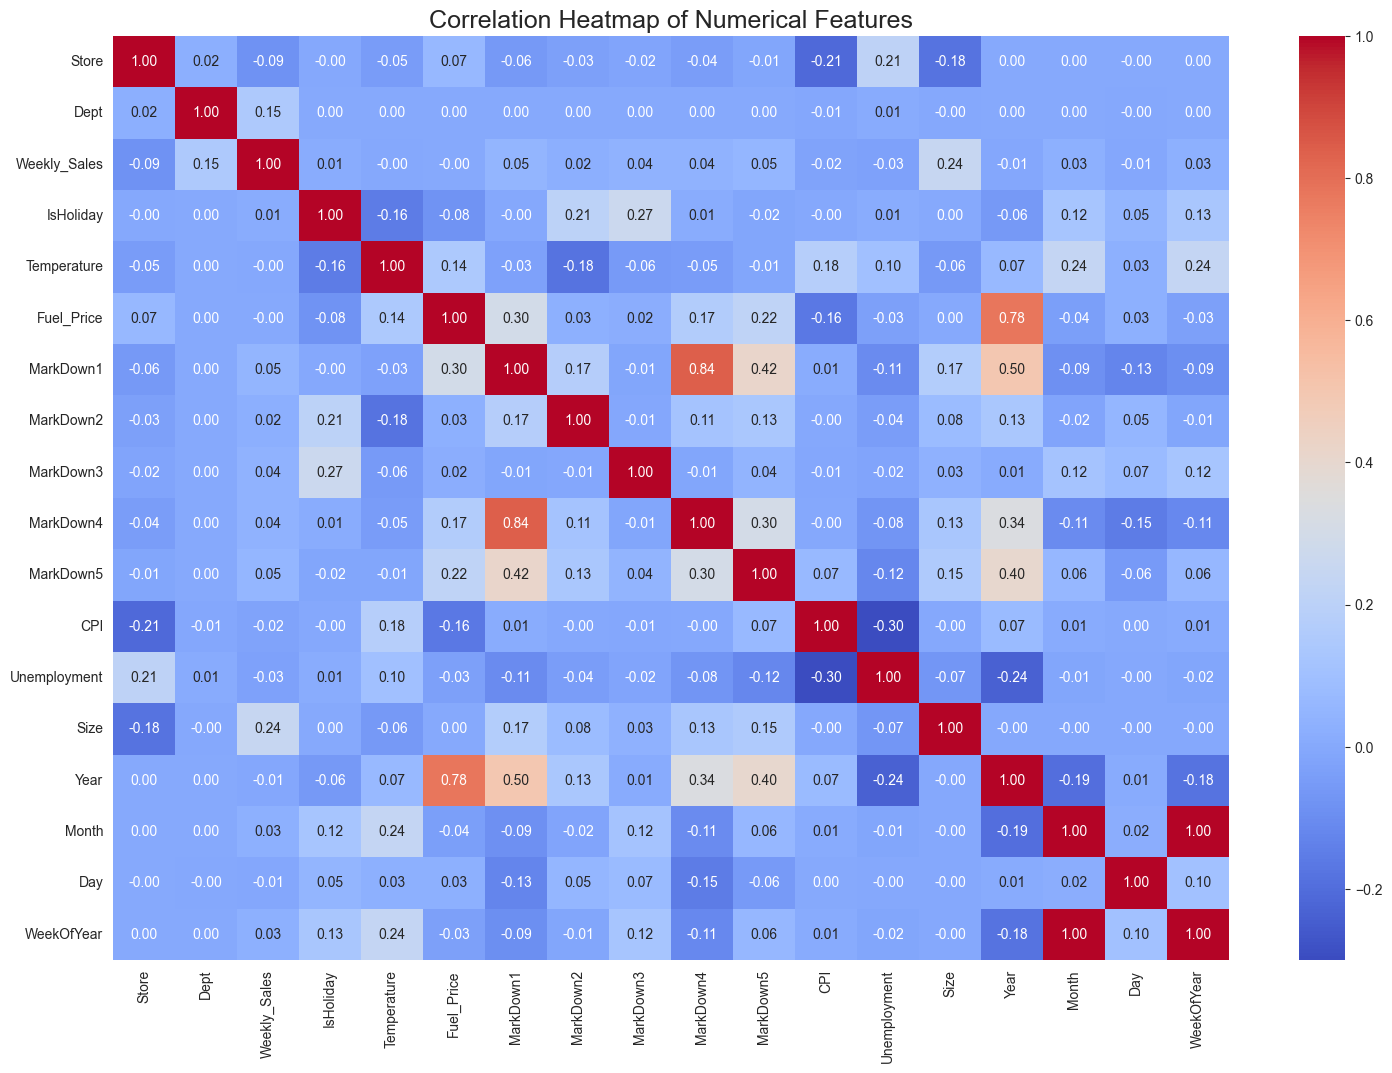

In [36]:
# Select only numeric columns for correlation matrix
### FIX: Use the processed training dataframe 'train_processed_df'
numeric_cols = train_processed_df.select_dtypes(include=np.number)

plt.figure(figsize=(18, 12))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt=".2f", annot_kws={'size': 10})
plt.title('Correlation Heatmap of Numerical Features', fontsize=18)
plt.show()

In [37]:
### FIX: Combine train and test sets temporarily to create lag features correctly.
# This allows the lag for the first week of the test set to be the last week of the train set.

# Add an identifier before combining
train_processed_df['dset'] = 'train'
test_processed_df['dset'] = 'test'

# Combine, sort, and create lags
combined_df = pd.concat([train_processed_df, test_processed_df], ignore_index=True)
combined_df = combined_df.sort_values(by=['Store', 'Date']).reset_index(drop=True)

combined_df['Weekly_Sales_Lag1'] = combined_df.groupby('Store')['Weekly_Sales'].shift(1)
combined_df['Weekly_Sales_Lag4'] = combined_df.groupby('Store')['Weekly_Sales'].shift(4)

# Split back into train and test sets
train_final_df = combined_df[combined_df['dset'] == 'train'].copy()
test_final_df = combined_df[combined_df['dset'] == 'test'].copy()

# Drop the identifier column
train_final_df.drop('dset', axis=1, inplace=True)
test_final_df.drop('dset', axis=1, inplace=True)

# Drop rows with NaN values created by the lag operation FROM THE TRAINING SET ONLY
train_final_df.dropna(inplace=True)

print("Shape of final training data after lags:", train_final_df.shape)
print("Shape of final test data:", test_final_df.shape)

Shape of final training data after lags: (421390, 22)
Shape of final test data: (115064, 22)


In [38]:
# Map store 'Type' to numerical values for both dataframes
type_mapping = {'A': 1, 'B': 2, 'C': 3}
train_final_df['Type'] = train_final_df['Type'].map(type_mapping)
test_final_df['Type'] = test_final_df['Type'].map(type_mapping)

print("Final feature mapping complete.")

Final feature mapping complete.


In [39]:
### FIX: Outlier removal should ONLY be done on the training data.
# The model should be tested on data that includes potential outliers, as this is more realistic.

print(f"Shape of training data before outlier removal: {train_final_df.shape}")

# Calculate IQR bounds for 'Weekly_Sales' using only the training data
Q1 = train_final_df['Weekly_Sales'].quantile(0.25)
Q3 = train_final_df['Weekly_Sales'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create the new cleaned DataFrame by filtering out the outliers from the training set
train_cleaned_df = train_final_df[(train_final_df['Weekly_Sales'] >= lower_bound) & (train_final_df['Weekly_Sales'] <= upper_bound)].copy()

print(f"Shape of training data after outlier removal: {train_cleaned_df.shape}")

Shape of training data before outlier removal: (421390, 22)
Shape of training data after outlier removal: (385874, 22)


In [40]:
from sklearn.preprocessing import MinMaxScaler

### FIX: Create a proper time-series validation set from the TRAINING data.
# We will hold back the last few months of the training data to use for validation.
# The original 'test_df' is the final holdout set, not for validation.

# Step 1: Set 'Date' as the index
train_cleaned_df.set_index('Date', inplace=True)
train_sorted = train_cleaned_df.sort_index()

# Step 2: Perform a chronological split on the training data to create a validation set.
# The model will be trained up to a certain date and validated on the period immediately after.
# This mimics the real-world scenario of predicting the future.
validation_cutoff_date = '2012-07-01' 
train_data = train_sorted[train_sorted.index < validation_cutoff_date]
val_data = train_sorted[train_sorted.index >= validation_cutoff_date]

# Step 3: Define features (X) and target (y) for train and validation sets
X_train = train_data.drop('Weekly_Sales', axis=1)
y_train = train_data['Weekly_Sales']
X_val = val_data.drop('Weekly_Sales', axis=1)
y_val = val_data['Weekly_Sales']

print(f"Training data shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

# Step 4: Scale the features
# IMPORTANT: Fit the scaler ONLY on the training data, then transform both train and validation sets.
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)

print("\nData successfully prepared. Ready for model training.")

Training data shape: (339701, 20)
Validation set shape: (46173, 20)

Data successfully prepared. Ready for model training.


In [41]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

models = {
    'LinearRegression': LinearRegression(),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

results = {}

for name, model in models.items():
    print(f"--- Training {name} ---")
    model.fit(X_train_scaled, y_train)
    
    ### FIX: Predict and evaluate on the VALIDATION set (X_val_scaled, y_val)
    # This gives a realistic performance score on unseen data.
    y_pred = model.predict(X_val_scaled)
    
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    results[name] = {'MSE': mse, 'R2': r2}
    print(f'{name} - MSE on Validation Set: {mse:.2f}')
    print(f'{name} - R2 Score on Validation Set: {r2:.2f}\n') # This score will be much more realistic.

best_model_name = 'XGBoost'
best_model = models[best_model_name]

--- Training LinearRegression ---
LinearRegression - MSE on Validation Set: 106725636.61
LinearRegression - R2 Score on Validation Set: 0.17

--- Training XGBoost ---
XGBoost - MSE on Validation Set: 10116505.45
XGBoost - R2 Score on Validation Set: 0.92



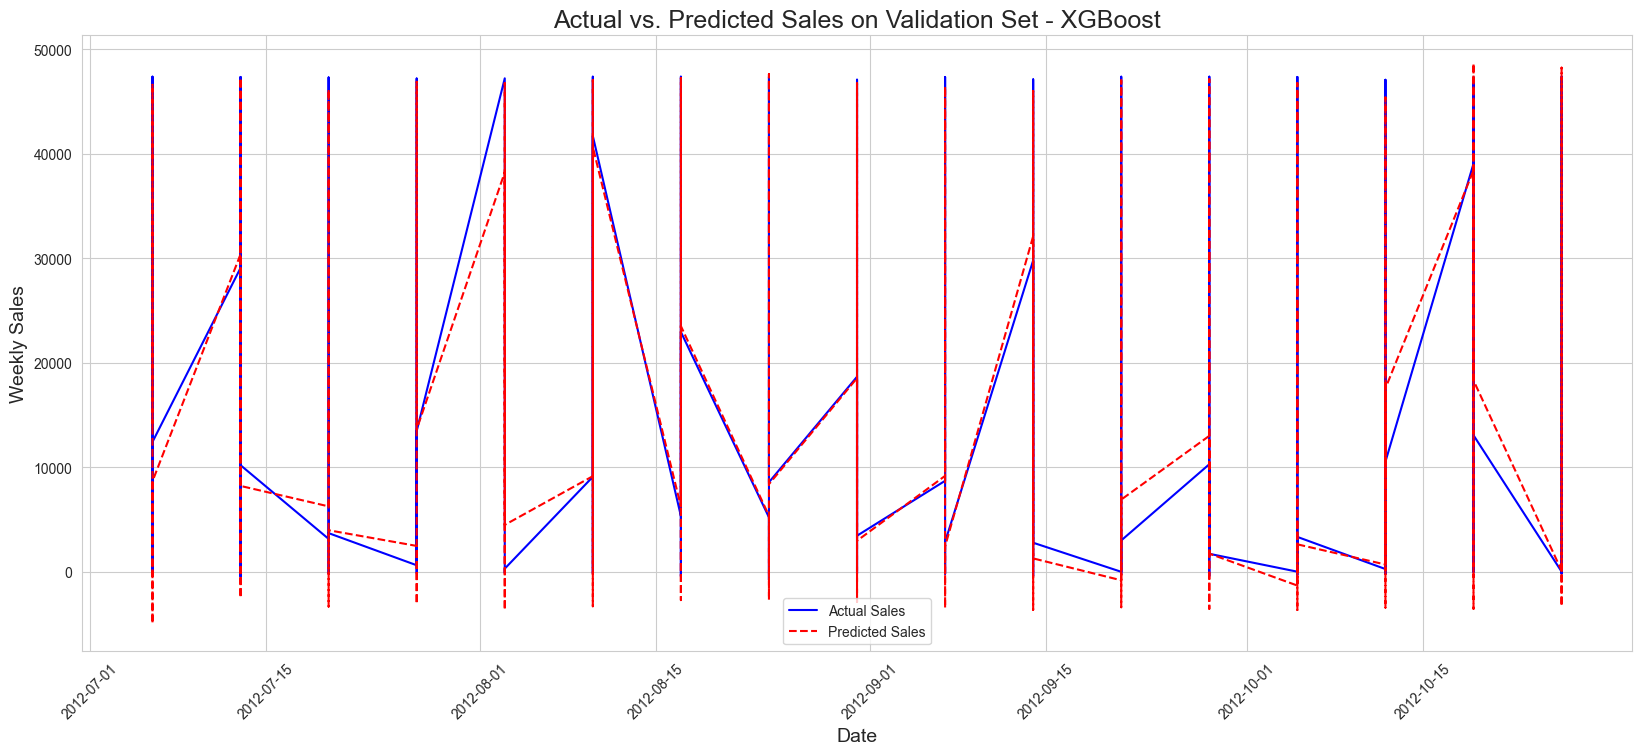

In [42]:
# Get predictions from the best model on the validation set
y_pred_final = best_model.predict(X_val_scaled)

# Create a DataFrame for easy plotting with dates
results_df = pd.DataFrame({
    'Actual': y_val,
    'Predicted': y_pred_final
})

# Plot the validation set results
plt.figure(figsize=(20, 8))
plt.plot(results_df.index, results_df['Actual'], label='Actual Sales', color='blue', linestyle='-')
plt.plot(results_df.index, results_df['Predicted'], label='Predicted Sales', color='red', linestyle='--')
plt.title(f'Actual vs. Predicted Sales on Validation Set - {best_model_name}', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.legend()
plt.xticks(rotation=45)
plt.show()

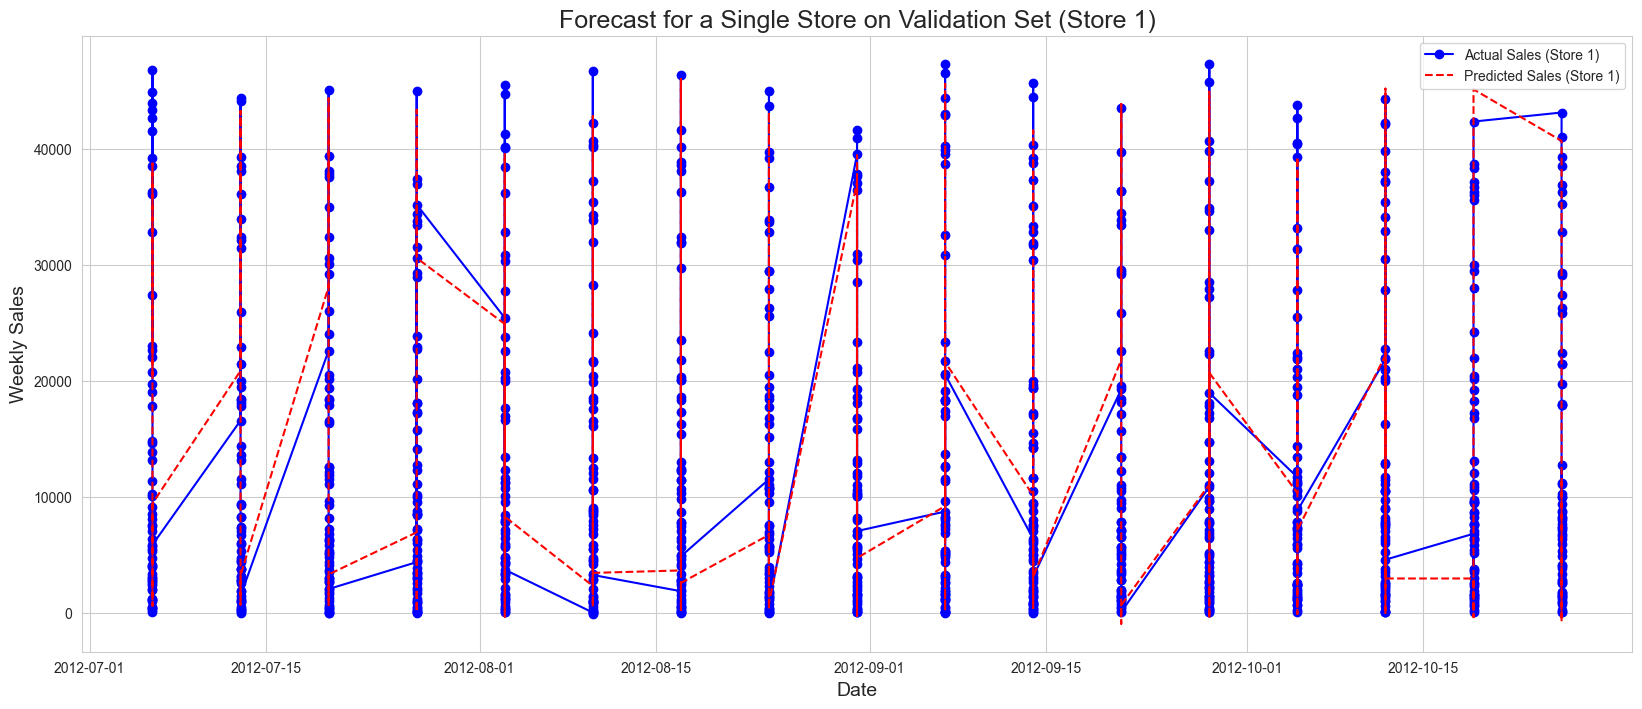

In [43]:
# Create a new results dataframe that also includes the Store number
results_df_with_store = X_val.copy()
results_df_with_store['Actual'] = y_val
results_df_with_store['Predicted'] = y_pred_final

# Choose a single store to visualize (e.g., Store 1)
store_to_plot = 1
store_results = results_df_with_store[results_df_with_store['Store'] == store_to_plot]

# Plot the results for the single store from the validation set
plt.figure(figsize=(20, 8))
plt.plot(store_results.index, store_results['Actual'], label=f'Actual Sales (Store {store_to_plot})', color='blue', marker='o')
plt.plot(store_results.index, store_results['Predicted'], label=f'Predicted Sales (Store {store_to_plot})', color='red', linestyle='--')
plt.title(f'Forecast for a Single Store on Validation Set (Store {store_to_plot})', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.legend()
plt.show()

Number of features for Deep Learning model: 20


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 32)             │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,217 (4.75 KB)

 Trainable params: 1,217 (4.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
10616/10616 ━━━━━━━━━━━━━━━━━━━━ 58s 5ms/step - loss: 132932032.0000 - val_loss: 122218992.0000
Epoch 2/100
10616/10616 ━━━━━━━━━━━━━━━━━━━━ 93s 6ms/step - loss: 120209352.0000 - val_loss: 116945040.0000
Epoch 3/100
10616/10616 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - loss: 116408560.0000 - val_loss: 112590376.0000
Epoch 4/100
10616/10616 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 113304944.0000 - val_loss: 109499344.0000
Epoch 5/100
10616/10616 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 111731360.0000 - val_loss: 108166408.0000
Epoch 6/100
10616/10616 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 111276592.0000 - val_loss: 107511280.0000
Epoch 7/100
10616/10616 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - loss: 111158888.0000 - val_loss: 107284000.0000
Epoch 8/100
10616/10616 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 111042520.0000 - val_loss: 107115336.0000
Epoch 9/100
10616/10616 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - loss: 110904936.0000 - val_loss: 106833184.0000
Epoch 10/100
10616/10616 ━━━

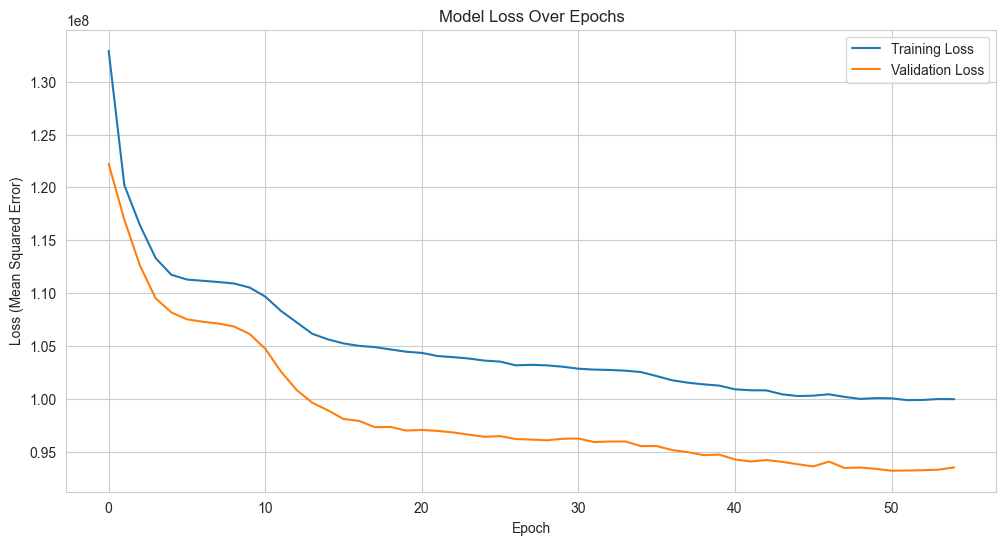

In [44]:

# Make sure you have run 'pip install tensorflow'
try:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Input, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    from tensorflow.keras.regularizers import l2

    n_features = X_train_scaled.shape[1]
    print(f"Number of features for Deep Learning model: {n_features}")

    Dmodel = Sequential([
        Input(shape=(n_features,)),
        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(1, activation='linear')
    ])

    Dmodel.compile(optimizer='adam', loss='mean_squared_error')
    Dmodel.summary()
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

    ### FIX: Use the proper validation data for training and early stopping.
    history = Dmodel.fit(
        X_train_scaled, y_train,
        epochs=100,
        validation_data=(X_val_scaled, y_val), # Use the validation set here
        callbacks=[early_stopping],
        verbose=1
    )
    
    dl_mse = Dmodel.evaluate(X_val_scaled, y_val, verbose=0)
    y_pred_dl = Dmodel.predict(X_val_scaled).flatten()
    dl_r2 = r2_score(y_val, y_pred_dl)
    
    print("\n--- Deep Learning Model Evaluation on Validation Set ---")
    print(f'TensorFlow Keras - MSE: {dl_mse:.2f}')
    print(f'TensorFlow Keras - R2 Score: {dl_r2:.2f}')
    
    # Plotting training & validation loss values
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    # This plot now correctly shows validation loss, which is the key indicator of overfitting.
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.ylabel('Loss (Mean Squared Error)')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

except ImportError:
    print("\nTensorFlow not found. Skipping Deep Learning model.")
except Exception as e:
    print(f"An error occurred during the DL model training: {e}")

In [45]:
import joblib

# --- Save the Model and Scaler ---

# We choose the best model you identified, which was XGBoost.
best_model_name = 'XGBoost'
best_model = models[best_model_name]

# Save the trained model to a file
joblib.dump(best_model, 'xgb_model.joblib')

# Save the scaler to a file
joblib.dump(scaler_X, 'scaler.joblib')

# Save the column order used for training
# This is CRUCIAL to ensure the app sends data in the correct feature order.
training_columns = X_train.columns.tolist()
joblib.dump(training_columns, 'training_columns.joblib')


print("Model, scaler, and training columns have been saved successfully.")
print("Files created: xgb_model.joblib, scaler.joblib, training_columns.joblib")
print("\nYou can now proceed to build the Streamlit app.")

Model, scaler, and training columns have been saved successfully.
Files created: xgb_model.joblib, scaler.joblib, training_columns.joblib

You can now proceed to build the Streamlit app.
